# Pracownia informatyczna - Modelowanie epidemii SARS-CoV-2

    Własność Uniwersytetu Przyrodniczego we Wrocławiu
    Autorzy: Gustaw Walaś, Wiktoria Wilman pod opieką prof Wojciecha Jakubowskiego
    Projekt modelu SIR oraz modelu ML na zajęcia Pracownia Informatyczna w roku akademickim 2020/2021

Jako prace projektowe należy zaliczyć: skomponowanie baz danych, analityczne rozwiązanie problemu modelu SIR przy pomocy języka Python, stworzenie interface’u użytkownika, zobrazowanie graficzne wyników modelowania danych, zbudowanie modelu Machine Learningowego (LSTM) oraz względne porównanie obu form predykcji.

### Dane wejściowe

##### Wybierz kraj do analizy

In [64]:
kraj='Zimbabwe'
#kraj='Poland'
#kraj='United Kingdom'
#kraj='Switzerland'

Wczytywanie wymaganych bibliotek

In [65]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.preprocessing import MinMaxScaler
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

warnings.filterwarnings('ignore')

### Część obliczeniowa

##### Kod modelu SIR

In [66]:
def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

##### Kod modelu Machine Learning'owego

In [67]:
model = Sequential()
model.add(Input(shape=(1, 30)))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(48))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))


model.compile(loss = 'mean_squared_error',
              optimizer = RMSprop(),
              metrics = ['mean_squared_error'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1, 48)             15168     
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 48)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 48)             18624     
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 48)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dropout_11 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

#### Wczytywanie danych

Dla modelu SIR

In [68]:
data_sir = pd.read_csv("data_model_sir.csv")
dane_sir = pd.DataFrame(data_sir, columns=['continent', 'location', 'date', 'total_cases', 'new_cases','reproduction_rate', 'population'])
dane_sir = dane_sir.fillna(0)
dane_sir = dane_sir[dane_sir.continent != 0]
dane_sir = dane_sir[dane_sir.location != 0]
continent = dane_sir["continent"].unique()
location = dane_sir["location"].unique()
data_sir = dane_sir["date"].unique()
print("Badamy ", dane_sir['location'].nunique() ,"krajów na ",dane_sir['continent'].nunique(),"kontynentach.")
print("Daty od", max(dane_sir['date']), " do ", min(dane_sir['date']), ", ogólnie ", dane_sir['date'].nunique(), "dni.")

Badamy  220 krajów na  6 kontynentach.
Daty od 2021-06-05  do  2020-01-01 , ogólnie  522 dni.


Dla modelu ML

Dla przyrostu całościowego

In [69]:
ml_data = pd.read_csv('data_model_ml.csv')
ml_data = ml_data.loc[ml_data['Country/Region'] == kraj]
ml_data = ml_data.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])

In [70]:
scaler = MinMaxScaler()
scaler.fit(ml_data.values.T)
ml_data = scaler.transform(ml_data.values.T)

In [71]:
X, y = [], []
time_steps = 30

for i in range(len(ml_data) - time_steps):
    x = ml_data[i:(i+time_steps), 0]
    X.append(x)
    y.append(ml_data[i+time_steps, 0])

X = np.array(X)
y = np.array(y)

In [72]:
split = int(len(X) * 0.8)

X_train = X[:split]
X_test = X
y_train = y[:split]
y_test = y

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Dla przyrostu dziennego (dla wybranych krajów)

In [73]:
dzienne=kraj+'_day'
ml_data = pd.read_csv('data_model_ml.csv')
dzienne_ml_data = ml_data.loc[ml_data['Country/Region'] == dzienne]
dzienne_ml_data = dzienne_ml_data.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
scaler.fit(dzienne_ml_data.values.T)
dzienne_ml_data = scaler.transform(dzienne_ml_data.values.T)
X_d, y_d = [], []
time_steps = 30

for i in range(len(dzienne_ml_data) - time_steps):
    x_d = dzienne_ml_data[i:(i+time_steps), 0]
    X_d.append(x_d)
    y_d.append(dzienne_ml_data[i+time_steps, 0])

X_d = np.array(X_d)
y_d = np.array(y_d)
split = int(len(X) * 0.8)

X_train_d = X_d[:split]
X_test_d = X_d
y_train_d = y_d[:split]
y_test_d = y_d

X_train_d = np.reshape(X_train_d, (X_train_d.shape[0], 1, X_train_d.shape[1]))
X_test_d = np.reshape(X_test_d, (X_test_d.shape[0], 1, X_test_d.shape[1]))

#### Obliczenia dla modelu SIR

Obliczenia dla modelu SIR dla dziennej liczby zakażonych

In [74]:
country_pop = pd.DataFrame()
country_pop['population']=(dane_sir['location']==kraj)
population = float(dane_sir.loc[country_pop.index[0], 'population'])
country_df = pd.DataFrame()
country_df['ConfirmedCases'] = dane_sir.loc[dane_sir['location']==kraj].total_cases.diff().fillna(0)
country_df = country_df[10:]
country_df['day_count'] = list(range(1,len(country_df)+1))
ydata = [i for i in country_df.ConfirmedCases]
xdata = country_df.day_count
ydata_d = np.array(ydata, dtype=float)
xdata_d = np.array(xdata, dtype=float)
N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0
popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted_d = fit_odeint(xdata, *popt)

Wykres SIR dla dziennej liczby zakażonych

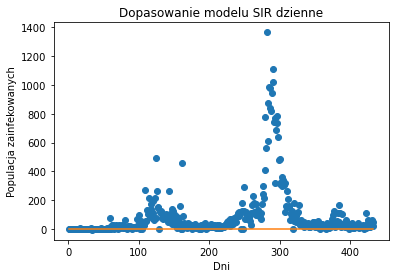

Optimal parameters: beta = 1.0  and gamma =  1.0


In [75]:
plt.plot(xdata_d, ydata_d, 'o')
plt.plot(xdata_d, fitted_d)
plt.title("Dopasowanie modelu SIR dzienne")
plt.ylabel("Populacja zainfekowanych")
plt.xlabel("Dni")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

Obliczenia dla modelu SIR dla pełnej liczby zakażonych

In [76]:
country_df = pd.DataFrame()
dates=pd.DataFrame()
dates= dane_sir.loc[dane_sir['location']==kraj].groupby(["date"]).sum()
population = float(dane_sir.loc[country_pop.index[0], 'population'])
country_df=dates['total_cases']
country_df=country_df.to_frame()
country_df['day_count'] = list(range(1,len(country_df)+1))
ydata = [i for i in country_df.total_cases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)
N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0
popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata, maxfev=1000000)
fitted = fit_odeint(xdata, *popt)

Wykres SIR dla pełnej liczby zakażonych

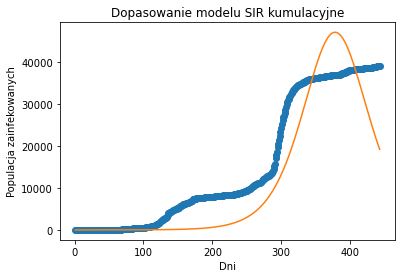

Optimal parameters: beta = 0.6610259457920633  and gamma =  0.6287667890087102


In [77]:
plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Dopasowanie modelu SIR kumulacyjne")
plt.ylabel("Populacja zainfekowanych")
plt.xlabel("Dni")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

#### Obliczenia dla modelu Machine Learning

Obliczenia dla modelu ML dla ogólnej liczby zakażonych

In [78]:
batchsize = 200
epochs =  18

learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-10)

history = model.fit(X_train,
                    y_train,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])


Epoch 1/18
2/2 [==============================] - 1s 292ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.2646 - val_mean_squared_error: 0.2646 - lr: 0.0010
Epoch 2/18
2/2 [==============================] - 0s 12ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.2469 - val_mean_squared_error: 0.2469 - lr: 0.0010
Epoch 3/18
2/2 [==============================] - 0s 14ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.2292 - val_mean_squared_error: 0.2292 - lr: 0.0010
Epoch 4/18
2/2 [==============================] - 0s 12ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.2103 - val_mean_squared_error: 0.2103 - lr: 0.0010
Epoch 5/18
2/2 [==============================] - 0s 11ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.1904 - val_mean_squared_error: 0.1904 - lr: 0.0010
Epoch 6/18
2/2 [==============================] - 0s 11ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.1693 - val_mean_sq

Wykres dla ogólnej liczby zakażonych

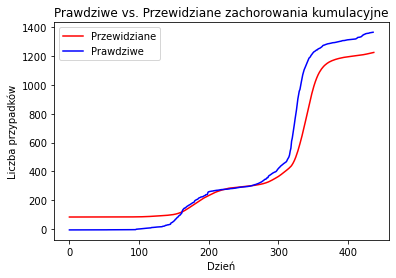

In [79]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

plt.plot(y_pred, color='red')
plt.plot(y_test, color='blue')
plt.title('Prawdziwe vs. Przewidziane zachorowania kumulacyjne')
plt.ylabel('Liczba przypadków')
plt.xlabel('Dzień')
plt.legend(['Przewidziane', 'Prawdziwe'])

Obliczenia modelu ML dla dziennej liczby zakażonych

In [80]:
batchsize = 200
epochs =  20

learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-10)

history = model.fit(X_train_d,
                    y_train_d,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])


Epoch 1/20
2/2 [==============================] - 0s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0550 - val_mean_squared_error: 0.0550 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - 0s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0569 - val_mean_squared_error: 0.0569 - lr: 0.0010
Epoch 3/20
2/2 [==============================] - 0s 13ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0587 - val_mean_squared_error: 0.0587 - lr: 0.0010
Epoch 4/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2/2 [==============================] - 0s 12ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0606 - val_mean_squared_error: 0.0606 - lr: 0.0010
Epoch 5/20
2/2 [==============================] - 0s 12ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0612 - val_mean_squa

Wykres dla dziennej liczby zakażonych

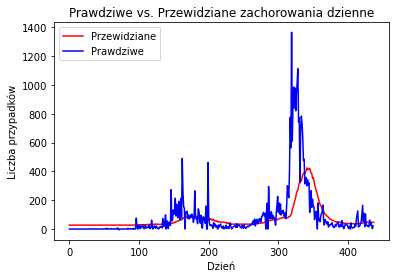

In [81]:
y_pred_d = model.predict(X_test_d)
y_pred_d = scaler.inverse_transform(y_pred_d)
y_test_d = scaler.inverse_transform(y_test_d.reshape(-1,1))

plt.plot(y_pred_d, color='red')
plt.plot(y_test_d, color='blue')
plt.title('Prawdziwe vs. Przewidziane zachorowania dzienne')
plt.ylabel('Liczba przypadków')
plt.xlabel('Dzień')
plt.legend(['Przewidziane', 'Prawdziwe'])

#### Porównanie wykresów

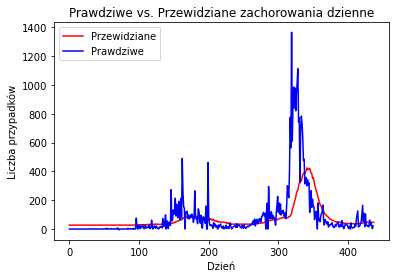

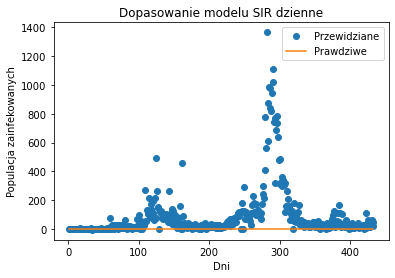

In [82]:
plt.plot(y_pred_d, color='red')
plt.plot(y_test_d, color='blue')
plt.title('Prawdziwe vs. Przewidziane zachorowania dzienne')
plt.ylabel('Liczba przypadków')
plt.xlabel('Dzień')
plt.legend(['Przewidziane', 'Prawdziwe'])
plt.show()

plt.plot(xdata_d, ydata_d, 'o')
plt.plot(xdata_d, fitted_d)
plt.title("Dopasowanie modelu SIR dzienne")
plt.ylabel("Populacja zainfekowanych")
plt.xlabel("Dni")
plt.legend(['Przewidziane', 'Prawdziwe'])
plt.show()


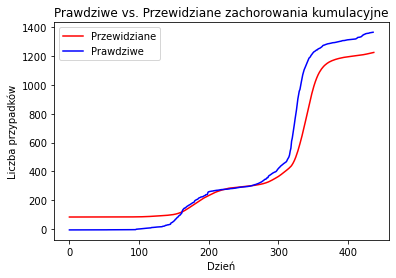

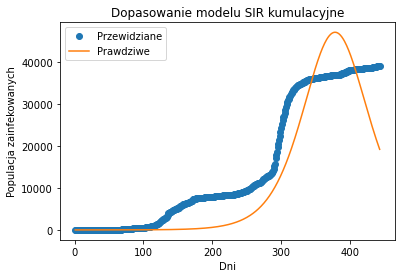

In [83]:
plt.plot(y_pred, color='red')
plt.plot(y_test, color='blue')
plt.title('Prawdziwe vs. Przewidziane zachorowania kumulacyjne')
plt.ylabel('Liczba przypadków')
plt.xlabel('Dzień')
plt.legend(['Przewidziane', 'Prawdziwe'])
plt.show()

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Dopasowanie modelu SIR kumulacyjne")
plt.ylabel("Populacja zainfekowanych")
plt.xlabel("Dni")
plt.legend(['Przewidziane', 'Prawdziwe'])
plt.show()